In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import glob
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
from keras.preprocessing import image
import os
from sklearn.preprocessing import LabelEncoder
from keras.utils.np_utils import to_categorical
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from keras.layers import Dense, Dropout, Activation, Flatten,Input
from keras.layers import Convolution2D, MaxPooling2D,ZeroPadding2D, GlobalAveragePooling2D, AveragePooling2D
from keras.models import Model
import tensorflow as tf
from keras.callbacks import ModelCheckpoint, EarlyStopping

In [ ]:
!unzip /content/gdrive/MyDrive/LVTN/Model/dataset_characters.zip -d "/content/"

32543


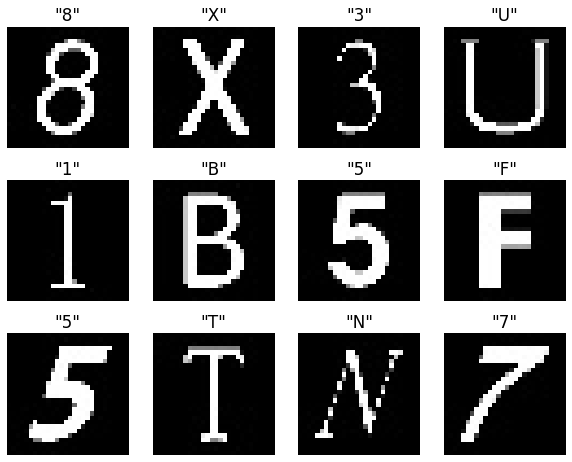

In [ ]:
dataset_paths = glob.glob("/content/dataset_characters/**/*.jpg")

cols=4
rows=3
fig = plt.figure(figsize=(10,8))
plt.rcParams.update({"font.size":14})
grid = gridspec.GridSpec(ncols=cols,nrows=rows,figure=fig)
print(len(dataset_paths))
# create a random list of images will be displayed
np.random.seed(45)
rand = np.random.randint(0,len(dataset_paths),size=(cols*rows))

# Plot example images
for i in range(cols*rows):
    fig.add_subplot(grid[i])
    img = image.load_img(dataset_paths[rand[i]])
    label = dataset_paths[rand[i]].split(os.path.sep)[-2]
    plt.title('"{:s}"'.format(label))
    plt.axis(False)
    plt.imshow(img)

In [ ]:
# Arange input data and corresponding labels
X=[]
labels=[]
for image_path in dataset_paths:
  label = image_path.split(os.path.sep)[-2]
  img=image.load_img(image_path,target_size=(80,80))
  img=image.img_to_array(img)
  X.append(img)
  labels.append(label)
X = np.array(X,dtype="float16")
labels = np.array(labels)
print("[INFO] Find {:d} images with {:d} classes".format(len(X),len(set(labels))))
# perform one-hot encoding on the labels
lb = LabelEncoder()
lb.fit(labels)
labels = lb.transform(labels)
y = to_categorical(labels)
# save label file so we can use in another script
np.save('license_character_classes.npy', lb.classes_)
# split 10% of data as validation set
(trainX, testX, trainY, testY) = train_test_split(X, y, test_size=0.10, stratify=y, random_state=42)
# generate data augumentation method
image_gen = ImageDataGenerator(rotation_range=10,
                              width_shift_range=0.1,
                              height_shift_range=0.1,
                              shear_range=0.1,
                              zoom_range=0.1,
                              fill_mode="nearest"
                              )

[INFO] Find 32543 images with 31 classes


In [ ]:
# Create our model with pre-trained MobileNetV2 architecture from imagenet
def create_model(lr=1e-4,decay=1e-4/25, training=False,output_shape=y.shape[1]):
    baseModel = MobileNetV2(weights="imagenet", 
                            include_top=False,
                            input_tensor=Input(shape=(80, 80, 3)))

    headModel = baseModel.output
    headModel = AveragePooling2D(pool_size=(3, 3))(headModel)
    headModel = Flatten(name="flatten")(headModel)
    headModel = Dense(128, activation="relu")(headModel)
    headModel = Dropout(0.5)(headModel)
    headModel = Dense(output_shape, activation="softmax")(headModel)
    
    model = Model(inputs=baseModel.input, outputs=headModel)
    
    if training:
        # define trainable lalyer
        for layer in baseModel.layers:
            layer.trainable = True
            
        # compile model
        optimizer = tf.keras.optimizers.Adam(lr=lr, decay = decay)
        model.compile(loss="categorical_crossentropy", optimizer=optimizer,metrics=["accuracy"])    
        
    return model

# initilaize initial hyperparameter
INIT_LR = 1e-4
EPOCHS = 30

model = create_model(lr=INIT_LR, decay=INIT_LR/EPOCHS,training=True)

9420800/9406464 [==============================] - 0s 0us/step


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
BATCH_SIZE = 64

my_checkpointer = [
                EarlyStopping(monitor='val_loss', patience=5, verbose=0),
                ModelCheckpoint(filepath="License_character_recognition.h5", verbose=1, save_weights_only=True)
                ]

result = model.fit(image_gen.flow(trainX, trainY, batch_size=BATCH_SIZE), 
                   steps_per_epoch=len(trainX) // BATCH_SIZE, 
                   validation_data=(testX, testY), 
                   validation_steps=len(testX) // BATCH_SIZE, 
                   epochs=EPOCHS, callbacks=my_checkpointer)

Epoch 1/30
457/457 [==============================] - ETA: 0s - loss: 1.4510 - accuracy: 0.6183
Epoch 1: saving model to License_character_recognition.h5
457/457 [==============================] - 1022s 2s/step - loss: 1.4510 - accuracy: 0.6183 - val_loss: 1.8937 - val_accuracy: 0.5656
Epoch 2/30
457/457 [==============================] - ETA: 0s - loss: 0.3708 - accuracy: 0.9028
Epoch 2: saving model to License_character_recognition.h5
457/457 [==============================] - 961s 2s/step - loss: 0.3708 - accuracy: 0.9028 - val_loss: 0.5692 - val_accuracy: 0.8590
Epoch 3/30
457/457 [==============================] - ETA: 0s - loss: 0.2398 - accuracy: 0.9377
Epoch 3: saving model to License_character_recognition.h5
457/457 [==============================] - 928s 2s/step - loss: 0.2398 - accuracy: 0.9377 - val_loss: 0.2056 - val_accuracy: 0.9450
Epoch 4/30
380/457 [=======================>......] - ETA: 2:14 - loss: 0.1852 - accuracy: 0.9520

In [ ]:
# save model architectur as json file
model_json = model.to_json()
with open("MobileNets_character_recognition.json", "w") as json_file:
  json_file.write(model_json)

In [ ]:
!cp /content/License_character_recognition.h5 /content/gdrive/MyDrive
!cp /content/license_character_classes.npy /content/gdrive/MyDrive

In [ ]:
# Load model architecture, weight and labels

model.load_weights('/content/License_character_recognition.h5')
print("[INFO] Model loaded successfully...")

labels = LabelEncoder()
labels.classes_ = np.load('license_character_classes.npy')
print("[INFO] Labels loaded successfully...")

[INFO] Model loaded successfully...
[INFO] Labels loaded successfully...
